In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm

In [3]:
import geopandas as gpd
from shapely.geometry import *

In [4]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [5]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [6]:
def get_ensemble(name,data_vars,htape,keys,paramkey,p=True):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=p,preprocess=preprocess)

    #fix up time dimension
    if htape=='h0' or htape=='h1':
        ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug

    #specify extra variables    
    if htape=='h0':
        extras     = ['grid1d_lat','grid1d_lon']
    elif htape=='h1':
        extras     = ['pfts1d_lat','pfts1d_lon','pfts1d_wtgcell','pfts1d_itype_veg']
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    return ds

In [203]:
def byhand(t,p):
    t1 = -5  #    tundra-boreal
    t2 =  3  #    boreal-temperate
    t3 = 20  # temperate-tropical

    tvals = [-np.inf,t1,t2,t3,np.inf]
    bvals = [9,8,4,1]


    for i in range(4):
        if (t>tvals[i])&(t<=tvals[i+1]):
            b = bvals[i]

    td = 15; pd=60; bd=3  #desert
    if (t>td)&(p<pd):
        b = bd

    return b

In [193]:
fp = './whit/Whittaker_biomes.shp'
data = gpd.read_file(fp)
og   = data.biome_id.copy(deep=True).values

In [194]:
newb = np.array([9,8,7,6,5,4,1,2,3])
data.biome_id=newb #more logical order

In [197]:
df = pd.read_csv('./whit/Whittaker_biomes.csv')
x  = df.biome_id.values 

In [199]:
for i in 1+np.arange(9):
    ix = df0.biome_id==i
    b  = newb[og==i]
    x[ix]=b
df.biome_id=x

In [137]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/surv.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

In [138]:
datavars = ['GPP','TBOT','RAIN','SNOW']
ds  = get_ensemble('CTL2010',datavars,'h0',['OAAT0000'],paramkey).isel(ens=0)

In [139]:
ny=10
tbot = 1/365/ny*(month_wts(ny)*ds.TBOT).sum(dim='time').compute()-273.15  #degC
gpp=(24*60*60*month_wts(10)*ds.GPP).groupby('time.year').sum().mean(dim='year').compute() #gC/m2/yr
rain = 24*60*60/10*(month_wts(ny)*ds.RAIN).groupby('time.year').sum().mean(dim='year').compute()  #cm/yr
snow = 24*60*60/10*(month_wts(ny)*ds.SNOW).groupby('time.year').sum().mean(dim='year').compute()  #cm/yr
prec = rain+snow

In [204]:
bclass = np.zeros(400)+np.nan
for i in range(400):
    if (tbot[i]<0)&(gpp[i]==0):
        bclass[i]=0  #ice
    else:
        ptf = gpd.GeoDataFrame({'geometry':[Point(tbot[i],prec[i])]})
        x=gpd.overlay(ptf, data, how='intersection')
        if len(x)>0:
            bclass[i] = x.biome_id.values
        else:
            bclass[i] = byhand(tbot[i],prec[i])


In [215]:
c = np.zeros([10,3])
c[1,:] = [9,91,31]
c[2,:] = [171,215,102]
c[3,:] = [218,203,111]
c[4,:] = [29,196,130]
c[5,:] = [136,246,72]
c[6,:] = [205,108,60]
c[7,:] = [245,245,159]
c[8,:] = [91,56,9]
c[9,:] = [160,211,216]
c = c/256

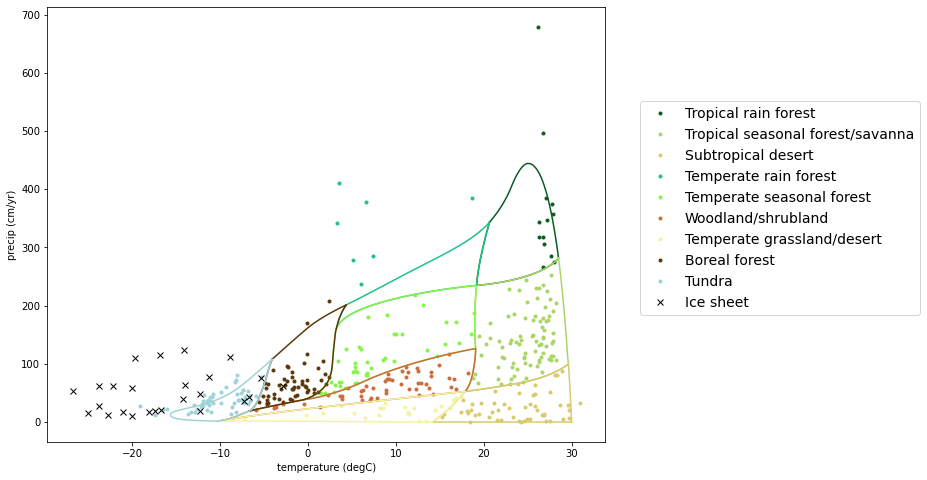

In [217]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
biomes = np.unique(df.biome_id.values)
ll=[]
for i in 1+np.arange(9):
    ix = bclass==i
    plt.plot(tbot[ix],prec[ix],'.',color=c[i,:])
    ll.append(data.biome[data.biome_id==i].values[0])

ix = bclass==0
plt.plot(tbot[ix],prec[ix],'kx')
ll.append('Ice sheet')

    
plt.legend(ll,bbox_to_anchor = (1.05, 0.8),fontsize=14)
for i in 1+np.arange(9):
    ix = df.biome_id==i
    t = df.temp_c[ix]
    p = df.precp_cm[ix]
    plt.plot(t,p,'-',color=c[i,:])

plt.xlabel('temperature (degC)')
plt.ylabel('precip (cm/yr)');


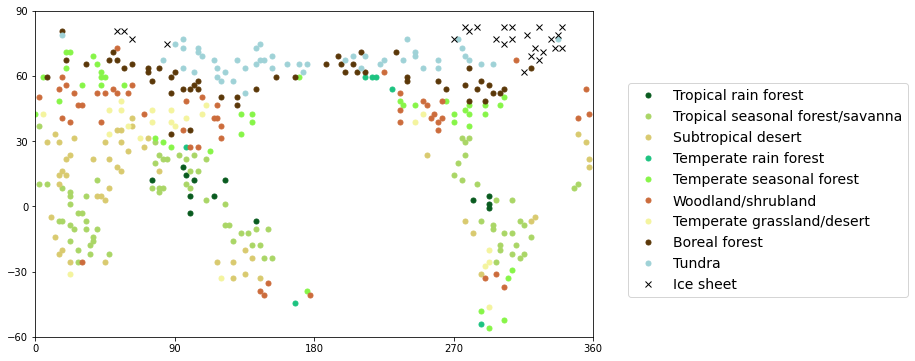

In [233]:
fig = plt.figure(figsize=[10,6])
ll = []
for i in 1+np.arange(9):
    ix = bclass==i
    plt.plot(ds.grid1d_lon[ix],ds.grid1d_lat[ix],'.',color=c[i,:],markersize=10)
    ix = data.biome_id==i
    ll.append(data.biome[ix].values[0])
ix = bclass==0
plt.plot(ds.grid1d_lon[ix],ds.grid1d_lat[ix],'kx')
ll.append('Ice sheet')
plt.legend(ll,bbox_to_anchor = (1.05, 0.8),fontsize=14)
plt.ylim([-60,90])
plt.xlim([0,360])
plt.yticks(-60+30*np.arange(6))
plt.xticks(90*np.arange(5));

### save to netcdf

In [234]:
ds_out = xr.Dataset()

In [235]:
da = xr.DataArray(bclass,coords={'gridcell':ds.gridcell})

In [236]:
ds_out['biome']=da
for v in ['grid1d_lat','grid1d_lon']:
    ds_out[v]=ds[v]

In [237]:
ds_out

<xarray.Dataset>
Dimensions:     (gridcell: 400)
Coordinates:
  * gridcell    (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
Data variables:
    biome       (gridcell) float64 5.0 4.0 5.0 5.0 7.0 ... 0.0 0.0 0.0 0.0 0.0
    grid1d_lat  (gridcell) float64 ...
    grid1d_lon  (gridcell) float64 ...

In [238]:
b_ids  = 1+np.arange(9)
bnames = [data.biome[data.biome_id==i].values[0] for i in b_ids]
b_ids  = [0,*b_ids]
bnames = ['Ice sheet',*bnames]
da = xr.DataArray(bnames,coords={'biome_id':b_ids})

In [239]:
ds_out['biome_name']=da

In [242]:
ds_out.to_netcdf('whit/whitkey.nc')